In [1]:
import os 
import subprocess 
import json 
import matplotlib.pyplot as plt
from pathlib import Path 
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm 

%matplotlib inline 

## Helper functions 

- Check HDR 
- Bitrate distribution 

In [3]:
#Check for True HDR
def is_video_hdr(video_path):
    """
    Check if the video at the given path is HDR.

    Args:
    - video_path (str): The path to the video file.

    Returns:
    - bool: True if the video is HDR, False otherwise.
    """
    cmd = [
    "ffprobe", 
    "-v", "error", 
    "-show_streams",
    "-select_streams", "v:0",
    "-print_format", "json",
    video_path
    ]

    result = subprocess.run(cmd, capture_output=True, text=True)
    video_info = json.loads(result.stdout)

    video_stream = video_info["streams"][0]

    # Checking some common HDR indicators in the metadata
    # This can be extended based on more specific requirements
    if ("color_transfer" in video_stream and video_stream["color_transfer"] == "smpte2084") or \
        ("color_space" in video_stream and video_stream["color_space"] in ["bt2020nc", "bt2020c"]) or \
        ("bits_per_raw_sample" in video_stream and int(video_stream["bits_per_raw_sample"]) > 8):
        return True

    return False


#Check for bitrate distribution for all HDR videos; skip and flag if not true HDR 
def bitrate_distribution(path_list, output_dir, qp = 0, compression=False):
    """
    Args:
    - path (str): The path to the video file.
    - output_dir: The output path to compressed videos
    - qp (int): quantization parameter, default = 0
    
    Returns:
    - bitrate: dictionary with key as path to video file and value as bitrate with qp=0
    """

    # Step 1: Encode all videos with qp=0 or crf=0
    input_files = path_list  # list of complete input video paths
    
    if compression:
        output_directory = output_dir  # Replace with the path to your output directory
        if not os.path.exists(output_dir):
            os.mkdir(output_dir)
        
        #Path(output_directory).mkdir(parents=True, exist_ok=True)

        for input_path in tqdm(input_files):
            input_file = input_path.split("/")[-1]
            output_path = os.path.join(output_directory, input_file)
            #print("Input_File: ", input_path)
        
            # Get codec name
            result = subprocess.run(["ffprobe", "-v", "error", "-select_streams", "v:0", "-show_entries", "stream=codec_name", "-of", "default=noprint_wrappers=1", input_path], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
            codec_name = result.stdout.split('=')[1].strip()
            #print("Codec_In_Original_File: ", codec_name)
                
            # Set codec and qp/crf option based on codec name
            if codec_name == 'h264':
                codec_option = ["-c:v", "libx264", "-qp", "0"]
            elif codec_name == 'hevc' or codec_name == 'h265':
                codec_option = ["-c:v", "libx265", "-x265-params", "qp=0"]
            elif codec_name == 'vp9':
                codec_option = ["-c:v", "libvpx-vp9", "-crf", "0"]
            else:
                print(f"Unsupported codec {codec_name} for file {input_file}. using vp9" ) #Skipping...")
                codec_option = ["-c:v", "libvpx-vp9", "-crf", "0"]
                #continue
            
            #skip if compressed already exists
            if os.path.exists(output_path):
                continue
            # Run ffmpeg command with appropriate codec and qp/crf option
            subprocess.run(["ffmpeg", "-v", "error", "-i", input_path] + codec_option + [output_path])

    # Step 2: Calculate Bitrate
    bitrates = {}

    for input_path in tqdm(input_files):
        output_file = input_path.split("/")[-1]
        if compression:
            output_path = os.path.join(output_directory, output_file)
        else: 
            output_path = input_path
        
        # Check if output file exists (it might not exist if we skipped it in Step 1)
        if not os.path.exists(output_path):
            continue
        
        # Get file size in bits
        file_size_bits = os.path.getsize(output_path) * 8  # os gives size in bytes, so multiply by 8 to get bits

        # Get video duration in seconds
        result = subprocess.run(["ffprobe", "-v", "error", "-show_entries", "format=duration", "-of", "default=noprint_wrappers=1", output_path], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
        duration_sec = float(result.stdout.split('=')[1].strip())

        # Calculate bitrate
        bitrate = file_size_bits / duration_sec
        bitrates[output_path] = bitrate

    return bitrates
    

## SKIP 


### Example data 

Replace the data path with your own data path. 


In [8]:
# Load HDR paths from csv
core_dir_path = "path/to/dataset"
csv_path = "path/to/csv/for/hdr.csv"
df = pd.read_csv(csv_path)
print("Total HDR video count: {}".format(len(df)))

# Getting the full path
def base_fold_path(row):
    return os.path.join(core_dir_path, row["Base_Path"].split("/")[-2]+"/"+row["Name(+Duration)"])

# All video paths
df["full_file_path"] = df.apply(base_fold_path, axis=1)
vid_path = df["full_file_path"].to_list()

non_hdr = []
# Check if all videos are True HDR:
for v in tqdm(vid_path):
    #print(f"Checking {v}...")
    if is_video_hdr(v):
        continue
        #print(f"{v} is HDR.")
    else:
        print(f"{v} is not HDR.")
        non_hdr.append(v)

# Remove non-hdr videos from list. 
vid_path = [x for x in vid_path if x not in non_hdr]

# Save the filtered list as .npy 
np.save("true_hdr.npy", np.array(vid_path, dtype=object), allow_pickle=True)


FileNotFoundError: [Errno 2] No such file or directory: 'path/to/csv/for/hdr.csv'

### Checking Bitrate distribution

In [7]:
core_dir_path = "path/to/dataset"
#load the numpy list 
vid_path = np.load("true_hdr.npy", allow_pickle=True)
print(vid_path[0])
#get the bitrate distribution
bitrates_dict = bitrate_distribution(vid_path, os.path.join("/",os.path.join(*core_dir_path.split('/')[:-2]),"temp_HDRYT_qp_0/"), 0)
bitrates = list(bitrates_dict.values())
with open("bitrate_dict.json", "w") as json_file:
    json.dump(bitrates_dict, json_file, indent=4)


/scratch/09032/saini_2/HDR_YT/YT-HDR/HDR_#Shorts_YT_keywords_8M_10kwords/xvi3bEmCCDs_41.webm


100%|██████████| 7781/7781 [13:08<00:00,  9.87it/s]


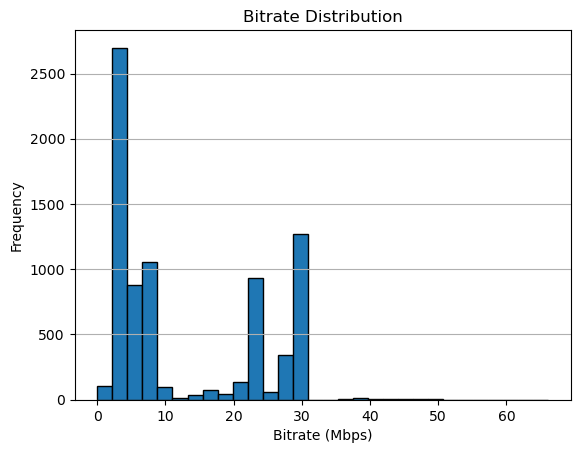

[22.022020424656528, 23.527506085498743, 3.9091093536121675, 6.823489786959328, 4.093342381321437, 28.805923596524565, 27.030702883409948, 23.457374192589167, 28.657658596730926, 28.594010485177773, 16.24769677478331, 27.974902171951978, 28.78378086023254, 2.425117202581214, 2.4418573711155314, 6.870287254524451, 6.536653998214513, 28.967506820566634, 27.748059849471197, 3.4989667285821353, 23.297973749193112, 5.8722706390844595, 6.67406659656502, 23.39547356555277, 4.101689378032003, 23.37810544258271, 6.914336551387022, 23.25127537351115, 23.40210891135231, 5.825913122999543, 23.02666015384615, 28.921330455082686, 4.170573481565576, 23.470645568015488, 4.1067300653799235, 22.410198796093287, 6.894800107037731, 4.0690812923996775, 6.3300813117120835, 2.4082056990944585, 6.2069831350814075, 22.14788955996549, 5.802409414072077, 3.9143978720031005, 4.10274295908128, 26.13603202248908, 4.136580489977729, 28.918330634540233, 3.0994619759036146, 4.0892581469050455, 4.1076617564888025, 29.0

In [24]:
with open("bitrate_dict.json", "r") as json_file:
    bitrates_dict = json.load(json_file)
bitrates = list(bitrates_dict.values())
#bps to Mbps 
bitrates = [i/1000000 for i in bitrates]

# Step 3: Draw the Distribution
plt.hist(bitrates, bins=30, edgecolor='black')
plt.title('Bitrate Distribution')
plt.xlabel('Bitrate (Mbps)')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

print(bitrates)


## HIDRO-VQA HDR Data 


In [55]:
# Geting the metadata from all video and save in csv file. 
""" 
Meta data:

Resolution, 
FPS,
Codec,
Bit depth,
Bitrate,
Duration,
Size,
Colorspace,
Color transfer,
Color primaries,
Chroma location,
"""
from pathlib import Path
import os 
import json 
import subprocess 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path 
from tqdm import tqdm 

#path to all videos
video_root = '/media/ss223464/JoshuaUTA/SantaFe/Dataset/10k_word_10_20_mins'
vid_list = os.listdir(video_root)
video_path = [video_root+"/"+v for v in vid_list if v.split('.')[-1] in ['mp4', 'mkv', 'mov', 'webm']]
print(f"Total video count: {len(video_path)}")
# save the metadata in panda dataframe
df = pd.DataFrame(columns=['video_name', 'video_path', 'resolution', 'width', 'height', 'fps', 'codec', 'pix_fmt', 'bit_depth', 'bitrate(Mbps)', 'duration(s)', 'size(b)', 'colorspace', 'color_transfer', 'color_range', 'color_primaries']) 

count = 0
for v in tqdm(video_path):
    #print(f"Checking {v}...")
    try:
        cmd = [
        "ffprobe", 
        "-v", "error", 
        "-show_streams",
        "-select_streams", "v:0",
        "-print_format", "json",
        v
        ]
        
        result = subprocess.run(cmd, capture_output=True, text=True)

        video_info = json.loads(result.stdout)

        video_stream = video_info["streams"][0]
    except:
        print(f"{v} doesn't have metadata or correct container info!")
        continue

    # Adding each metadata to dataframe 
    v_name = v.split('/')[-1]
    v_path = v
    width = video_stream["width"]
    height = video_stream["height"]
    #if resolution is not available, calculate from width and height
    if "display_aspect_ratio" not in video_stream:
        resolution = str(video_stream["width"]) + "x" + str(video_stream["height"])
    else:
        resolution = video_stream["display_aspect_ratio"]
    codec = video_stream["codec_name"]
    pix_fmt = video_stream["pix_fmt"]
    # if bit depth is not available,fill None 
    if "bits_per_raw_sample" not in video_stream:
        bit_depth = None
    else:
        bit_depth = video_stream["bits_per_raw_sample"]
    #if duration is not available, get from ffprobe show_entries      
    if "duration" not in video_stream:
        cmd_duration = [
            "ffprobe",
            "-v", "error",
            "-show_entries", "format=duration",
            "-of", "default=noprint_wrappers=1:nokey=1",
            v
        ]
        result_duration = subprocess.run(cmd_duration, capture_output=True, text=True)
        duration = result_duration.stdout
    else:
        duration = video_stream["duration"]
    #if bitrate is not available, calculate from size and duration. Get the size from os 
    bitrate = (os.path.getsize(v)*8) / (float(result_duration.stdout)*1000000)
    #if size is not available, get it from os 
    if "size" not in video_stream:
        size = os.path.getsize(v)*8
    else:
        size = video_stream["size"]
    color_range = video_stream["color_range"]    
    colorspace = video_stream["color_space"]
    color_transfer = video_stream["color_transfer"]
    color_primaries = video_stream["color_primaries"]
    #if fps is not available, calculate from duration and nb_frames
    if "avg_frame_rate" not in video_stream:
        fps = video_stream["nb_frames"] / video_stream["duration"]     
    else:
        fps = video_stream["avg_frame_rate"]
    
    # adding all the metadata to dataframe s

    df.loc[count] = [v_name, v_path, resolution, width, height, fps, codec, pix_fmt, bit_depth, bitrate, duration, size, colorspace, color_transfer, color_range, color_primaries]

    count +=1
      
df.head(5)

#split the fps column into two columns: num and den and get the float value of fps. 
df["fps_float"] = df["fps"].apply(lambda x: float(x.split("/")[0])/float(x.split("/")[1]))

#make new column with bitrate(in MBps)/(resolution*frame_rate) and then filter based on that.
#use MBps not bps
df["bit_per_frame_per_pixel"] = (df["bitrate(Mbps)"])/(df["width"]*df["height"]*df["fps_float"])

#save the dataframe as csv file
df.to_csv('SantaFe_meta_data_1066.csv', index=False)


#filtering the dataframe based on width and height, bitrate, duration, fps.
#df = pd.read_csv("SantaFe_meta_data_1066.csv")

#df["normalised_bitrate"] = df["bitrate"]/(df["width"]*df["height"]*df["fps"])
df["bit_per_frame_per_pixel"].head(5)

#filter all 4k videos 
df_filtered = df[(df["width"]==3840) & (df["height"]==2160)]

#mean for bitrate 
print(df_filtered["bitrate(Mbps)"].mean())

#print(df)
#filtering based on bitrate per frame per pixel from HDR LIVE dataset (average)
threshold = 28/(3840*2160*60) #0.32

df_filtered = df_filtered[(df_filtered["bit_per_frame_per_pixel"]>=threshold) & (df_filtered["fps_float"]>=50)]
print("Final Assumed Pristine Vids",len(df_filtered))

#save the dataframe as csv file
df_filtered.to_csv('SantaFe_meta_data_filtered_bfpHDRLIVE_4K_50fps.csv', index=False)




Total video count: 1066


  0%|          | 0/1066 [00:00<?, ?it/s]

 12%|█▏        | 133/1066 [00:24<02:13,  6.98it/s]

/media/ss223464/JoshuaUTA/SantaFe/Dataset/10k_word_10_20_mins/C0uU39BqZag_894.mp4 doesn't have metadata or correct container info!


100%|██████████| 1066/1066 [02:54<00:00,  6.11it/s]

25.674121587663112
Final Assumed Pristine Vids 411


### Checking the final fps distribution 

,video_name,video_path,resolution,width,height,fps,codec,pix_fmt,bit_depth,bitrate(Mbps),duration(s),size(b),colorspace,color_transfer,color_range,color_primaries,fps_float,bit_per_frame_per_pixel
2,Yox26GPG7TU_1021.webm,/media/ss223464/JoshuaUTA/SantaFe/Dataset/10k_...,16:9,3840,2160,60/1,vp9,yuv420p10le,NaN,29.861050,1020.650,30477680528,bt2020nc,arib-std-b67,tv,bt2020,60.0,6.000243e-08
3,RgTL88tPwR8_887.webm,/media/ss223464/JoshuaUTA/SantaFe/Dataset/10k_...,16:9,3840,2160,60/1,vp9,yuv420p10le,NaN,28.878328,886.017,25586689768,bt2020nc,arib-std-b67,tv,bt2020,60.0,5.802776e-08
6,Nt3eGBv8h3Q_601.webm,/media/ss223464/JoshuaUTA/SantaFe/Dataset/10k_...,16:9,3840,2160,60/1,vp9,yuv420p10le,NaN,28.743015,600.700,17265929192,bt2020nc,smpte2084,tv,bt2020,60.0,5.775587e-08
7,GmoltNtieu0_893.webm,/media/ss223464/JoshuaUTA/SantaFe/Dataset/10k_...,16:9,3840,2160,60/1,vp9,yuv420p10le,NaN,29.110592,892.850,25991392104,bt2020nc,arib-std-b67,tv,bt2020,60.0,5.849447e-08
12,YjQida5xoSc_603.webm,/media/ss223464/JoshuaUTA/SantaFe/Dataset/10k_...,16:9,3840,2160,60/1,vp9,yuv420p10le,NaN,28.922080,602.883,17436630560,bt2020nc,smpte2084,tv,bt2020,60.0,5.811568e-08


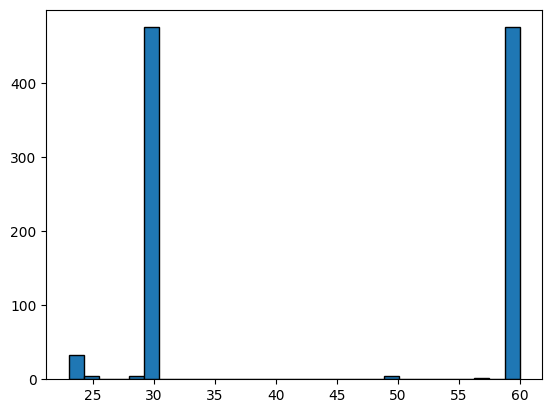

In [61]:
#histogram for fps values 
plt.hist(df["fps_float"], bins=30, edgecolor='black')
df_filtered.head(5)

### Checking the Filtering criteria for data amount 

In [ ]:
#filtering the dataframe based on width and height, bitrate, duration, fps.
import pandas as pd
df = pd.read_csv("SantaFe_meta_data_1066.csv")
#split the fps column into two columns: num and den and get the float value of fps. 
df["fps_float"] = df["fps"].apply(lambda x: float(x.split("/")[0])/float(x.split("/")[1]))

#make new column with bitrate(in MBps)/(resolution*frame_rate) and then filter based on that.
#use MBps not bps
df["bit_per_frame_per_pixel"] = (df["bitrate(Mbps)"])/(df["width"]*df["height"]*df["fps_float"])
#df["normalised_bitrate"] = df["bitrate"]/(df["width"]*df["height"]*df["fps"])
df["bit_per_frame_per_pixel"].head(5)

#filter all 4k videos 
df = df[(df["width"]==3840) & (df["height"]==2160)]

#mean for bitrate 
print(df["bitrate(Mbps)"].mean())

#print(df)
#filtering based on normalised bitrate
threshold = 28/(3840*2160*60) #0.32

df_filtered = df[(df["bit_per_frame_per_pixel"]>=threshold) & (df["fps_float"]>=50)]
print(len(df_filtered))

df_filtered_2 = df[(df["bitrate(Mbps)"]>=25)]
print(len(df_filtered_2))


### Test for videos giving error in ffprobe streams


In [49]:

video_p = "/media/ss223464/JoshuaUTA/SantaFe/Dataset/10k_word_10_20_mins/C0uU39BqZag_894.mp4"
#check ffprobe output for one video 
cmd = [
    "ffprobe", 
    "-v", "error", 
    "-show_streams",
    "-select_streams", "v:0",
    "-print_format", "json",
    video_p
    ]

result = subprocess.run(cmd, capture_output=True, text=True)

video_info = json.loads(result.stdout)

video_stream = video_info["streams"][0]

print(video_stream)


result = subprocess.run(["ffprobe", "-v", "error", "-show_entries", "format=duration", "-of", "default=noprint_wrappers=1", video_p], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

print(result.stdout)
print(result.stderr)

#get bitrate from ffprobe output 
result = subprocess.run(["ffprobe", "-v", "error", "-select_streams", "v:0", "-show_entries", "stream=bit_rate", "-of", "default=noprint_wrappers=1", video_p], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

print(result.stdout)
print(result.stderr)

#show all metadata 
result = subprocess.run(["ffprobe", "-v", "error", "-show_streams", "-select_streams", "v:0", "-print_format", "json", video_p], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

print(result.stdout)
print(result.stderr)


KeyError: 'streams'

## Don't need to run transcoding and/or clipping here. Improved and cleaned up version of the code is provided `get_clips_MultiProcess.py`. 

# Transcoding all data safely to use same transfer function. 

- PQ 10 bit is larger space than HLG, so PQ is used.


- First We need to evaluate current state of tranfer functions in our data.
- Then we need to make sure while converting to PQ, we are not losing any information (need to preserve the quality of the video)
- Make sure the colors and dynamic range are preserved and not affected in any way. 
- Trancode using ffmpeg or videolib (abhinau) to PQ 10 bit/or whichever is prominent in our data (given it is bigger space)




In [2]:
"""  
Checking all available unique transfer functions, colorspaces, pix_fmts, codecs, color_range, color_primaries

- Overall statistics 
- Combined statistics, i.e. transfer function match with colorspace, pix_fmt, codec, color_range

"""

import pandas as pd
import numpy as np
import os

df = pd.read_csv("./SantaFe_meta_data_filtered_bfpHDRLIVE_4K_50fps.csv")
print(f"Total videos: {len(df)}")

#unique color_transfer
print(df["color_transfer"].unique())
#unique colorspace
print(df["colorspace"].unique())
#unique pix_fmt
print(df["pix_fmt"].unique())
#unique codec
print(df["codec"].unique())
#unique color_range
print(df["color_range"].unique())
#unique color_primaries
print(df["color_primaries"].unique())

# Lets the check the count of color_transfers, since it has two categories: PQ and HLG 
print(df["color_transfer"].value_counts())

#get one video with hlg transfer function 
df_hlg = df[df["color_transfer"]=="arib-std-b67"]
df_hlg['video_path'].to_list()[0]

Total videos: 411
['arib-std-b67' 'smpte2084']
['bt2020nc']
['yuv420p10le']
['vp9']
['tv']
['bt2020']
arib-std-b67    209
smpte2084       202
Name: color_transfer, dtype: int64


'/media/ss223464/JoshuaUTA/SantaFe/Dataset/10k_word_10_20_mins/Yox26GPG7TU_1021.webm'

In [4]:
"""
Total videos: 411
['arib-std-b67' 'smpte2084']
['bt2020nc']
['yuv420p10le']
['vp9']
['tv']
['bt2020']
arib-std-b67    209
smpte2084       202
Name: color_transfer, dtype: int64

- Since, there are only 2 unique color_transfer, HLG and PQ. With 50% each.
- We need to trancode all HLG video to PQ. (making sure the dynamic range, colors, and overall quality is preserved)


Steps: 
- Get all HLG videos from the list.
- Transcode them to PQ. [Keep the same resolution, codec, fps, bitrate, pix_fmt, color_range] - preserve the quality and dynamic range.
    - Direct using ffmpeg
    OR
    - may need to convert to yuv first  
    - then convert to linear light [decode]
    - then encode again using PQ.

- Save them in new folder.
"""


# Get all HLG videos from the list.
df_hlg = df[df["color_transfer"]=="arib-std-b67"]
print(f"Total HLG videos: {len(df_hlg)}")


Total HLG videos: 209
29.861049848625875


In [ ]:
""" 
- That while this conversion will technically give you a video in the PQ format, 
the appearance might not be the same as if the content was originally graded in PQ. 
The conversion might not fully preserve the original artistic intent or appearance of the HLG content in the PQ domain.


-This conversions are pure mathematical and does not take care of artistic choice.


NOTE *Important - Direct conversion using ffmpeg works (verified using hlg-pq-hlg and compare with avqt tool), 

NOTE *Important - but conversion through linear light does not work in ffmpeg (overly washed colors)

NOTE *Important - Using videolib(Abhinau's) for conversion from hlg to pq on yuv file fails. 

"""


"""
# Conversion through linear light does not. - Skipping

# convert to linear light (HLG)
!ffmpeg -i Yox26GPG7TU_1021_259.webm -vf "zscale=transfer=linear:transferin=arib-std-b67" -c:v libvpx-vp9 -c:a copy -pix_fmt yuv420p10le Yox26GPG7TU_1021_259_linear.webm

print("Linear Light Conversion done.")
#convert to PQ 
!ffmpeg -i Yox26GPG7TU_1021_259_linear.webm -vf "zscale=transfer=smpte2084:transferin=linear" -c:v libvpx-vp9 -c:a copy -pix_fmt yuv420p10le Yox26GPG7TU_1021_259_pq.webm
""" 



# Direct Conversion; Basically -vf is the filter which does kind tone mapping. we have to be careful with this filter. 
 
import subprocess

# Convert a video from HLG to PQ using FFmpeg
command = [
    'ffmpeg',
    '-i', 'Yox26GPG7TU_1021_259.webm',  # Input video file
    '-vf', 'zscale=transfer=smpte2084:transferin=arib-std-b67',
    '-c:v', 'libvpx-vp9',
    '-c:a', 'copy',  # Copy audio stream without re-encoding
    'Yox26GPG7TU_1021_pq_direct.webm'  # Output video file
]

#subprocess.run(command)

